In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import copy
import numpy as np
import matplotlib.pyplot as plt

train_data = torchvision.datasets.MNIST(
    root='./data/',
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

test_data = torchvision.datasets.MNIST(
    root='./data/',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

BATCH_SIZE = 100
LR_SCSG = 0.06

EPOCH = 50
LARGE_BATCH_NUMBER=25
INNER_LOOPS = 10

# Setup DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [2]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 512),
            nn.Linear(512, 10))
        
    def forward(self, inputs):
        inputs = inputs.view(-1, 28 * 28)
        x = self.model(inputs)
        return F.log_softmax(x,dim=1)
    
    def partial_grad(self, inputs, targets):
        """
        Function to compute the stochastic gradient
        args : input, loss_function
        return : loss
        """
        outputs = self.forward(inputs)
        # compute the partial loss
        loss = F.nll_loss(outputs, targets)

        # compute gradient
        loss.backward()
        return loss.detach()
    
    def calculate_loss_grad(self, dataset, large_batch_num):
        """
        Function to compute the large-batch loss and the large-batch gradient
        args : dataset, loss function, number of samples to be calculated
        return : total_loss, full_grad_norm
        """

        total_loss = 0.0

        for idx, data in enumerate(dataset):
            # only calculate the sub-sampled large batch
            if idx > large_batch_num - 1:
                break
            # load input
            inputs, targets = data
            inputs, targets = torch.FloatTensor(inputs).cuda(), torch.LongTensor(targets).cuda()

            # calculate loss
            total_loss += self.partial_grad(inputs, targets)
            
        total_loss /= large_batch_num

        return total_loss

In [3]:
def calculate_grad_variance(net, train_loader, large_batch_num):
    net_grads = []
    for p_net in net.parameters():
        net_grads.append(p_net.grad.data)
    clone_net = copy.deepcopy(net)
    _ = clone_net.calculate_loss_grad(train_loader, large_batch_num)

    clone_net_grad = []
    for p_net in clone_net.parameters():
        clone_net_grad.append(p_net.grad.data/large_batch_num)
    del clone_net
    
    variance = 0.0
    for g1, g2 in zip(net_grads, clone_net_grad):
        variance += (g1-g2).norm(2) ** 2
    variance = torch.sqrt(variance)
    return variance

In [25]:
def sarah_step(net, optimizer, train_loader, test_loader, inner_iter_num):
    """
    Function to updated weights with a SARAH backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    large_batch_num = LARGE_BATCH_NUMBER
    batch_size = BATCH_SIZE
    
    # record previous net full gradient
    pre_net_full = copy.deepcopy(net)
    # record previous net mini batch gradient
    pre_net_mini = copy.deepcopy(net)

    # Compute full grad
    optimizer.zero_grad()
    _ = net.calculate_loss_grad(train_loader, large_batch_num)

    for p_net in net.parameters():
        p_net.grad.data *= (1.0 / large_batch_num)
        
    optimizer.step()
        
    running_loss = []
    iter_num = 0.0
    grad_variances = []
    # Run over the train_loader
    for batch_id, batch_data in enumerate(train_loader):

        if batch_id > inner_iter_num - 1:
            break
        
        # record previous net full gradient
        for p_net, p_full in zip(net.parameters(), pre_net_full.parameters()):
            p_full.grad = copy.deepcopy(p_net.grad)
        
        # get the input and label
        inputs, targets = batch_data

        # wrap data and target into variable
        inputs, targets = torch.FloatTensor(inputs).cuda(), torch.LongTensor(targets).cuda()

        # compute previous stochastic gradient
        pre_net_mini.zero_grad()
        # take backward
        _ = pre_net_mini.partial_grad(inputs, targets)

        # compute current stochastic gradient
        optimizer.zero_grad()
        current_loss = net.partial_grad(inputs, targets)

        # take SCSG gradient step
        for p_net, p_mini, p_full in zip(net.parameters(), pre_net_mini.parameters(), pre_net_full.parameters()):
            p_net.grad.data = p_net.grad.data + p_full.grad.data - p_mini.grad.data
        
        grad_variances += [calculate_grad_variance(net, train_loader, LARGE_BATCH_NUMBER)]
        
        # record previous net mini batch gradient
        for p_mini, p_net in zip(pre_net_mini.parameters(), net.parameters()):
            p_mini.data = copy.deepcopy(p_net.data)
        
        optimizer.step()

        # print statistics
        running_loss += [current_loss.cpu().detach()]
        iter_num += 1.0

    # calculate training loss
    train_loss = np.mean(running_loss)

    # calculate test loss
    net.zero_grad()
    test_loss = net.calculate_loss_grad(test_loader, len(test_loader)/batch_size)

    return train_loss, test_loss, running_loss, grad_variances

In [26]:
def sgd_step(net, optimizer, train_loader, test_loader, inner_iter_num):
    """
    Function to updated weights with a SGD backpropagation
    args : net, optimizer, train_loader, test_loader, loss function, number of inner epochs, args
    return : train_loss, test_loss, grad_norm_lb
    """
    batch_size = BATCH_SIZE

    running_loss = []
    iter_num = 0.0
    grad_variances = []
    
    # Run over the train_loader
    for batch_id, batch_data in enumerate(train_loader):

        if batch_id > inner_iter_num - 1:
            break

        # get the input and label
        inputs, targets = batch_data

        # wrap data and target into variable
        inputs, targets = torch.FloatTensor(inputs).cuda(), torch.LongTensor(targets).cuda()

        # compute current stochastic gradient
        optimizer.zero_grad()

        outputs = net(inputs)
        current_loss = F.nll_loss(outputs, targets)
        current_loss.backward()
        
        grad_variances.append(calculate_grad_variance(net, train_loader, LARGE_BATCH_NUMBER))
        optimizer.step()

        # print statistics
        running_loss += [current_loss.cpu().detach()]
        iter_num += 1.0

    # calculate training loss
    train_loss = np.mean(running_loss)

    # calculate test loss
    net.zero_grad()
    test_loss = net.calculate_loss_grad(test_loader, len(test_loader)/batch_size)

    return train_loss, test_loss, running_loss, grad_variances

In [27]:
net = Model().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=LR_SCSG)
# optimizer = torch.optim.Adam(net.parameters())

sarah_loss_train = []
sarah_loss_test  = []
sarah_loss_all = []
sarah_grad_variances = []
# training
for epoch in range(EPOCH):
    inner_iter_num = INNER_LOOPS #np.random.geometric(1.0/(LARGE_BATCH_NUMBER + 1.0))
    # take one epoch scsg step
    cur_train_loss, cur_test_loss, cur_loss_all, cur_grad_variances\
        = sarah_step(net, optimizer, train_loader, test_loader, inner_iter_num)
    sarah_loss_train.append(cur_train_loss)
    sarah_loss_test.append(cur_test_loss)
    sarah_loss_all.extend(cur_loss_all)
    sarah_grad_variances.extend(cur_grad_variances)
    # print progress
    print('Epoch: ', epoch,
          '| train loss: %.8f' % cur_train_loss,
          '| test loss: %.8f' % cur_test_loss)

Epoch:  0 | train loss: 2.25856805 | test loss: 2.22563148
Epoch:  1 | train loss: 2.16873121 | test loss: 2.10951948
Epoch:  2 | train loss: 2.04106951 | test loss: 1.95664048
Epoch:  3 | train loss: 1.83669448 | test loss: 1.74722505
Epoch:  4 | train loss: 1.57574391 | test loss: 1.42260504
Epoch:  5 | train loss: 1.30506325 | test loss: 1.13091886
Epoch:  6 | train loss: 1.05564010 | test loss: 1.03101885
Epoch:  7 | train loss: 0.87475044 | test loss: 0.79766828
Epoch:  8 | train loss: 0.80619633 | test loss: 0.69188499
Epoch:  9 | train loss: 0.68210614 | test loss: 0.51834786
Epoch:  10 | train loss: 0.61602533 | test loss: 0.61695981
Epoch:  11 | train loss: 0.56587040 | test loss: 0.50784665
Epoch:  12 | train loss: 0.54600179 | test loss: 0.45894650
Epoch:  13 | train loss: 0.51202267 | test loss: 0.54067075
Epoch:  14 | train loss: 0.47120506 | test loss: 0.37693647
Epoch:  15 | train loss: 0.51000702 | test loss: 0.57478774
Epoch:  16 | train loss: 0.46731338 | test loss: 0

In [7]:
net = Model().cuda()
optimizer = torch.optim.SGD(net.parameters(), lr=LR_SCSG)
# optimizer = torch.optim.Adam(net.parameters())

sgd_loss_train = []
sgd_loss_test  = []
sgd_loss_all = []
sgd_grad_variances = []
# training
for epoch in range(EPOCH):
    inner_iter_num = INNER_LOOPS # len(train_loader)/BATCH_SIZE
    # take one epoch scsg step
    cur_train_loss, cur_test_loss, cur_loss_all, cur_grad_variances\
        = sgd_step(net, optimizer, train_loader, test_loader, inner_iter_num)
    sgd_loss_train.append(cur_train_loss)
    sgd_loss_test.append(cur_test_loss)
    sgd_loss_all.extend(cur_loss_all)
    sgd_grad_variances.extend(cur_grad_variances)
    # print progress
    print('Epoch: ', epoch,
          '| train loss: %.8f' % cur_train_loss,
          '| test loss: %.8f' % cur_test_loss)

Epoch:  0 | train loss: 2.26994324 | test loss: 2.23908472
Epoch:  1 | train loss: 2.19144392 | test loss: 2.13233566
Epoch:  2 | train loss: 2.09121346 | test loss: 2.05903769
Epoch:  3 | train loss: 1.94598961 | test loss: 1.83296788
Epoch:  4 | train loss: 1.70621133 | test loss: 1.51880324
Epoch:  5 | train loss: 1.42572975 | test loss: 1.32322371
Epoch:  6 | train loss: 1.22495842 | test loss: 1.02715611
Epoch:  7 | train loss: 1.03898489 | test loss: 1.04194915
Epoch:  8 | train loss: 0.90122938 | test loss: 0.67495829
Epoch:  9 | train loss: 0.76308423 | test loss: 0.73839408
Epoch:  10 | train loss: 0.70966446 | test loss: 0.54543895
Epoch:  11 | train loss: 0.62089312 | test loss: 0.57860929
Epoch:  12 | train loss: 0.56709945 | test loss: 0.64728552
Epoch:  13 | train loss: 0.61416626 | test loss: 0.50086027
Epoch:  14 | train loss: 0.57696140 | test loss: 0.46547821
Epoch:  15 | train loss: 0.49448156 | test loss: 0.55566895
Epoch:  16 | train loss: 0.50787234 | test loss: 0

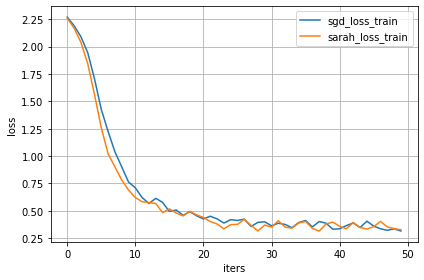

In [8]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_loss_train,label='sgd_loss_train')
axs.plot(x,sarah_loss_train,label='sarah_loss_train')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('train_loss_sarah.pdf')

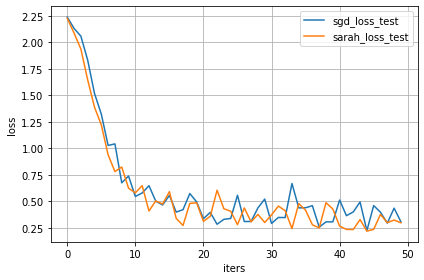

In [9]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_loss_test,label='sgd_loss_test')
axs.plot(x,sarah_loss_test,label='sarah_loss_test')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('test_loss_sarah.pdf')

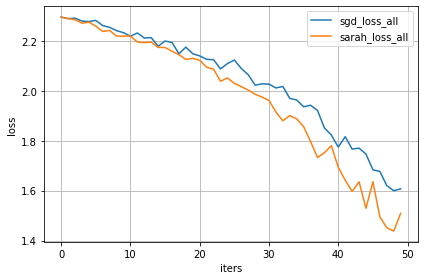

In [10]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_loss_all[:EPOCH],label='sgd_loss_all')
axs.plot(x,sarah_loss_all[:EPOCH],label='sarah_loss_all')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('all_loss_sarah.pdf')

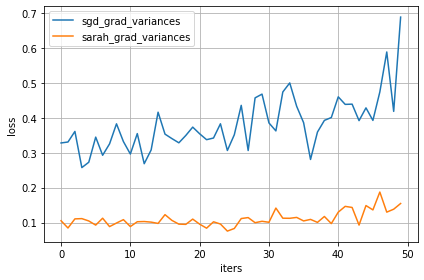

In [28]:
fig, axs = plt.subplots()
x = np.arange(EPOCH)
axs.plot(x,sgd_grad_variances[:EPOCH],label='sgd_grad_variances')
axs.plot(x,sarah_grad_variances[:EPOCH],label='sarah_grad_variances')
        
axs.set_xlabel('iters')
axs.set_ylabel('loss')
axs.grid(True)

fig.tight_layout()
plt.legend()
plt.savefig('grad_variances_sarah.pdf')